* 참조 깃헙
    * 모델 하나로 만들자.
* Base code
    * https://github.com/GunhoChoi/PyTorch-FastCampus/blob/master/07_Transfer_Learning/0_Pretrained_Basic/Transfer_Learning.ipyn
        * 모델 하나로 만들자.
    * 01_pretrainedVGG_media_v4
    * MediaClassifier_a_VGG
* MediaClassifier_c_inceptionv3

## 1. Settings
### 1) Important required libraries

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

### 2) Hyperparameter

In [5]:
batch_size= 2  #1
learning_rate = 0.0001
epoch = 100

n_node = 256  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## 2. Data Loader
### 1) Training data
### (Option1) Only real artwork from Web crawling

In [6]:
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Train"
#img_dir = "../images/car_dataset2/car_training"
#img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Train"

train_data = dset.ImageFolder(img_dir, transforms.Compose([     
            # ①(512)③②RCrop  <-- Best !!
            transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
            transforms.RandomCrop(imgsize),       # ③ RandomCrop
            transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

2895


### (Option2) Option1 + Textbook artwork

In [7]:
# img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Train"
# #img_dir = "../images/car_dataset2/car_training"
# #img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Train"

# train_data1 = dset.ImageFolder(img_dir, transforms.Compose([    
#             transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
#             transforms.RandomCrop(imgsize),       # ③ RandomCrop
#             transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
#             transforms.Scale(imgsize),
#             transforms.ToTensor()
#             ]))
# print(train_data1.__len__())
 
    
# #img_dir = "../../images/painting_dataset/real_artwork_textbook_refinement"
# img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement_small0.5_div/Train"
# train_data2 = dset.ImageFolder(img_dir, transforms.Compose([
#             # ①(512)③②RCrop  <-- Best !!
#             transforms.CenterCrop(imgsize*2),     # ① CenterCrop(512)
#             transforms.RandomCrop(imgsize),       # ③ RandomCrop
#             transforms.RandomHorizontalFlip(),    # ② RandomHorizontalFlip
    
# #             transforms.CenterCrop(imgsize),    
# #             transforms.RandomHorizontalFlip(),    
    
#             transforms.Scale(imgsize),
#             transforms.ToTensor()
#             ]))
# print(train_data2.__len__())

# #train_data = train_data1  
# train_data = list(train_data1) + list(train_data2)
# train_batch = data.DataLoader(train_data, batch_size=batch_size,
#                             shuffle=True, num_workers=2)

### 2) Development (validation), Test data

In [8]:
# 2. Dev data
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Valid"
#img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Valid"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)

# 3. Test data
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
#img_dir = "../../images/painting_dataset/real_artwork_textbook_div/Test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            #transforms.Scale(256),
            #transforms.RandomSizedCrop(224),
    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
        
nclass = len(dev_data.classes)
print("# of classes: %d" %nclass)
print(dev_data.classes)
print(dev_data.class_to_idx)
print(dev_data.__len__())

print("Training: %d, Dev: %d, Test: %d, " %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# for imgs, labels in train_batch:
#     for j in range(len(imgs)):
#         img = transforms.ToPILImage()(imgs[j])
#         plt.title("label: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

# 4. Synthesized data
img_dir = "../../images/painting_dataset/synthesized_evenCategory-no_paper_folder"
synth_data = dset.ImageFolder(img_dir, transforms.Compose([    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
synth_batch = data.DataLoader(synth_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
print("Synth: %d, " %synth_data.__len__()),

# 5. Textbook refinement data
#img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement"
img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement_small0.5_div/Test"
textbook_data = dset.ImageFolder(img_dir, transforms.Compose([    
            transforms.CenterCrop(size=imgsize),
            transforms.Scale(imgsize),
            transforms.ToTensor()
            ]))
textbook_batch = data.DataLoader(textbook_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
print("Textbook: %d" %textbook_data.__len__())

# of classes: 4
['oil', 'pastel', 'pencil', 'water']
{'water': 3, 'pastel': 1, 'oil': 0, 'pencil': 2}
620
Training: 2895, Dev: 620, Test: 621,  Synth: 160,  Textbook: 70


## 3. Model
### 1) Pretrained Inception-v3 Model

In [9]:
inceptionv3 = models.inception_v3(pretrained=True)

for name,module in inceptionv3.named_children():
    print(name)

# print(list(vgg.children())[0])
# print(list(vgg.children())[-1])

print("\n")

#cnt = 0
for i in inceptionv3.children():
    #print("yhk[%d]" %cnt),
    print(i)
    #cnt = cnt+1

/home/cgvmu/anaconda2/envs/pytorch/lib/python2.7/site-packages/torchvision-0.1.9-py2.7.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
Conv2d_3b_1x1
Conv2d_4a_3x3
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
AuxLogits
Mixed_7a
Mixed_7b
Mixed_7c
fc


BasicConv2d (
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
)
BasicConv2d (
  (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
)
BasicConv2d (
  (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
)
BasicConv2d (
  (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
)
BasicConv2d (
  (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
)
InceptionA (
  (branch1x1): BasicConv2d (
    (co

### 2) Customized Fully Model

In [10]:
class MyInceptionv3(nn.Module):
    def __init__(self):
        super(MyInceptionv3, self).__init__()
        #self.layer0 = nn.Sequential(*list(inceptionv3.children())[0:16])  # [0:16]: features(conv), [17]: classifier(fc)
        self.layer0 = nn.Sequential(*list(inceptionv3.children())[0:12])   # [0:12]: features(conv), [13]: AuxLogits
        self.layer1 = nn.Sequential(*list(inceptionv3.children())[14:16])  # [14:16]: features(conv), [17]: classifier(fc)
        self.layer2 = nn.Sequential(
            #nn.Linear(8*base_dim * fsize * fsize, 1024),
            nn.Linear(2048*30*30, n_node),   # 2048*30*30: out = self.layer0(x) 의 out 을 프린트하는 무식한 방법으로 알아냄.
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropratio),  # 0.3 만큼 drop 하자.
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
#             nn.Linear(n_node, n_node),
#             nn.BatchNorm1d(n_node),
#             nn.ReLU(),
#             nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass),
        )
        # weight initialization
        for m in self.layer2.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x):
        out = self.layer0(x)
        out = self.layer1(out)
        #print(out.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        out = out.view(out.size(0), -1)
        out = self.layer2(out)
        return out

### 3) Model on GPU

In [11]:
model = MyInceptionv3().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = False
    
for params in model.layer2.parameters():
    params.required_grad = True

In [12]:
for name in model.children():
    print(name)

Sequential (
  (0): BasicConv2d (
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (1): BasicConv2d (
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True)
  )
  (2): BasicConv2d (
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True)
  )
  (3): BasicConv2d (
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True)
  )
  (4): BasicConv2d (
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True)
  )
  (5): InceptionA (
    (branch1x1): BasicConv2d (
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64,

## 4. Optimizer & Loss

In [13]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

In [14]:
# # 하나만 모델에 넣어보자.
# for img, label in train_batch:
#     img = Variable(img, volatile=True).cuda()
#     label = Variable(label).cuda()
    
#     output = model(img)
#     #output = model.layer0(img)
#     #print(output.size())

## 5. Train

In [15]:
import utils

total_time = 0
disp_step = 10

to_train = False
if (to_train==False):
    netname = './nets/media_inceptionv3_RCrop_fixed.pkl'
    model = torch.load(netname)
else:
    print("1 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))    
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    synth_corr = utils.ComputeCorr(synth_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f, synth: %.2f" 
          %(train_corr, dev_corr, test_corr, synth_corr))
    model.train()
    
    netname = './nets/media_inceptionv3.pkl'

    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = False
#     for params in model.layer2.parameters():
#         params.required_grad = True        
#     for i in range(18, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            synth_corr = utils.ComputeCorr(synth_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, synth: %.2f, " 
                  %(train_corr, dev_corr, test_corr, synth_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

In [16]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

In [ ]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


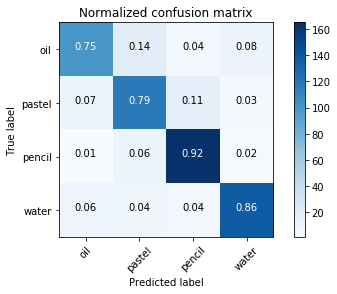

Confusion matrix, without normalization


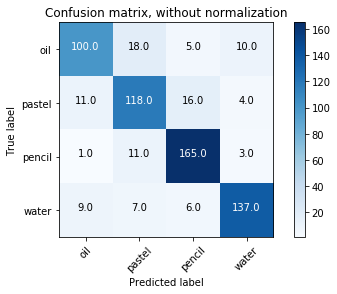

	 acc  |	 pre  |	 rec  |	 f1
 oil: 0.91 |	 0.83 |	 0.75 |	 0.79
 pastel: 0.85 |	 0.77 |	 0.79 |	 0.78
 pencil: 0.88 |	 0.86 |	 0.92 |	 0.89
 water: 0.94 |	 0.89 |	 0.86 |	 0.88
*accuracy: 0.90, precision: 0.84, recall: 0.83, *f1 score: 0.83


In [17]:
model.eval()
_,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

In [ ]:
model.eval()
utils.EvaluateClassifier(synth_batch, model, synth_data.classes, batch_size)

## 7. Visualize true & false predicted images

In [ ]:
model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.VisTFPred(dev_batch, model, dev_data.classes, batch_size, 2)

## 8. Evaluate by voting
* 주의: 반드시 random 하게 크롭할 것! center crop 만 하면 voting 하기 전과 정확히 같은 방법
    * 예) 
    * transforms.CenterCrop(imgsize*2),    
    * transforms.RandomCrop(imgsize),      

In [ ]:
# 1) Test data (basic & voting)
img_dir = "../../images/painting_dataset/real_artwork_divided_shffl_4K/Test"
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

In [ ]:
# 2) Synthesized data (basic & voting)
img_dir = "../../images/painting_dataset/synthesized_evenCategory-no_paper_folder"
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

In [ ]:
# 3) Textbook data (basic & voting)
img_dir = "../../images/painting_dataset/real_artwork_textbook/real_artwork_textbook_refinement_small0.5_div/Test"
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

## 9. Human test data (basic & voting)
* Human 설문에 사용된 data 의 원본 데이터로 성능 측정하자

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/1) RealArtwork" 
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/3) Synthesized" 
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)

In [ ]:
img_dir = "../../images/painting_dataset/HumanTest/2_Human2NetOrig/2) Textbook" 
utils.EvalData(img_dir, model, None, batch_size)
utils.EvalData(img_dir, model, "WSum", batch_size, 5)  # weighted sum (직접선거)